In [1]:
# Tratamiento de datos

import pandas as pd  # Manipulación y análisis de datos.
import numpy as np  # Soporte para vectores y matrices.

# Gráficos

import matplotlib.pyplot as plt  # Creación de gráficos estáticos, animados e interactivos.
from matplotlib import style  # Personalización del estilo de los gráficos.

# Preprocesado y modelado

from scipy.stats import pearsonr  # Coeficiente de correlación de Pearson.
from sklearn.model_selection import train_test_split  # División de datos en conjuntos de entrenamiento y prueba.
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error  # Métricas para evaluar modelos.
import statsmodels.api as sm  # Modelos estadísticos y econometricos.
import statsmodels.formula.api as smf  # Modelo estadísticos con fórmulas.
from statsmodels.stats.anova import anova_lm  # Análisis de varianza.
from scipy import stats  # Funciones estadísticas.
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler  # Preprocesamiento de datos.
import category_encoders  # Codificación de variables categóricas.
import missingno as msno  # Visualización de datos faltantes.
from sklearn.pipeline import Pipeline  # Cadena de transformaciones con un estimador final.
from sklearn.experimental import enable_iterative_imputer  # Permitir uso de IterativeImputer.
from sklearn.impute import IterativeImputer  # Imputación de datos faltantes.
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor  # Modelos de ensamble.
from sklearn.model_selection import GridSearchCV, cross_val_score  # Búsqueda de hiperparámetros y validación cruzada.

# Deep Learning
import tensorflow as tf  # Biblioteca de Deep Learning.
from tensorflow.keras import layers, models  # Construcción de modelos de deep learning.
from keras.callbacks import EarlyStopping, ReduceLROnPlateau  # Callbacks para controlar el entrenamiento.
from keras.models import Sequential  # Creación de modelos secuenciales.
from keras.layers import Dense, Dropout, BatchNormalization  # Capas para construir modelos.
from keras import regularizers  # Regularización de modelos.


In [2]:
# Cargamos el archivo csv con los datos

df_central = pd.read_csv("https://raw.githubusercontent.com/jesusvillaalvarez/TFM_KSCHOL/main/5.ARCHIVOS/df_central_2_1.csv")

df_central.head()


,Unnamed: 0,Fecha,Period,PREVISION,E_SIMEL,DESVIO,f_PREV_HIGH,f_PREV_LOW,f_RUN,Dia_Semana,Es_fin_semana,Año,Mes,Día
0,0,2021-01-01,1,0.0,0.0,0.0,0,0,0,4,False,2021,1,1
1,1,2021-01-01,2,0.0,0.0,0.0,0,0,0,4,False,2021,1,1
2,2,2021-01-01,3,0.0,0.0,0.0,0,0,0,4,False,2021,1,1
3,3,2021-01-01,4,0.0,0.0,0.0,0,0,0,4,False,2021,1,1
4,4,2021-01-01,5,0.0,0.0,0.0,0,0,0,4,False,2021,1,1


In [3]:
# Eliminamos las columnas innecesarias

df_central = df_central.drop(columns=['Unnamed: 0', 'DESVIO', 'f_PREV_HIGH', 'f_PREV_LOW'])



In [4]:
# Convertimos la columna 'Fecha' a Datetime para hacer las división en dos dfs

df_central['Fecha'] = pd.to_datetime(df_central['Fecha'])

# Dividimos el DataFrame en dos según las fechas especificas

df_inicio = df_central[df_central['Fecha'] <= '2023-10-31']
df_final = df_central[df_central['Fecha'] >= '2023-11-05']

# Eliminamos la columna 'Fecha' de ambos DataFrames para poder preparar el modelo de Deep Learning

df_inicio = df_inicio.drop(columns=['Fecha'])
df_final = df_final.drop(columns=['Fecha'])



In [5]:
# Preparamos df_inicio eliminando la variables objetivo del conjunto de entrenamiento (X) y especificamos la variable objetivo del conjunto de prueba (y)

X = df_inicio.drop('E_SIMEL', axis=1)
y = df_inicio['E_SIMEL']

# Dividimos los datos en conjuntos de entrenamiento y prueba

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizamos las características, paso necesario para el modelo de deep learning

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Verificamos las dimensiones de los conjuntos de datos para asegurarnos de que todo está correcto

(X_train_scaled.shape, X_test_scaled.shape, y_train.shape, y_test.shape)


((19764, 8), (4942, 8), (19764,), (4942,))

In [6]:
"""
Vistos los resultados negativos  de los dos modelo anteriores de deep learning para nuestro objetivo, vamos a experimentar
con otra arquitectura modificando hiperparámetros añadiendo más unidades en las capas ocultas, regularizaciones, normalizaciones,
añadiendo Dropout, además de afinar los Callbacks.

"""

'\nVistos los resultados negativos  de los dos modelo anteriores de deep learning para nuestro objetivo, vamos a experimentar\ncon otra arquitectura modificando hiperparámetros añadiendo más unidades en las capas ocultas, regularizaciones, normalizaciones,\nañadiendo Dropout, además de afinar los Callbacks.\n\n'

In [7]:
# Arquitectura del modelo

"""  
. configuramos un modelo secuencial donde la salida de una capa es la entrada de otra capa
. Vamos a incrementar el número de unidades (ahora 128) en la primera y segunda capa oculta para intentar capturar más complejidad.
. Regularización L2 para prevenir el sobreajuste
. Normalización por lotes para estabilizar y acelerar el entrenamiento
. en la segunda capa oculta añadimos Dropout: apagamos aleatoriamente un porcentaje de conexiones entre las neuronas. Reducimos respecto anteriores notebooks
. última capa de salida sin función de activación

"""


model = Sequential([
    
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],), kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),

    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)), Dropout(0.3),
    
    Dense(1)
])

# Mantenemos el optimizador 'adam' que ajusta la tasa de aprendizaje durante el entrenamiento, ajustando la función de pérdida y métricas si es necesario

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Ajustamos los callbacks disminuyendo el parámetro 'patience' y disminuyendo el 'min_lr' para tener una tasa de aprendizaje más amplio

early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, min_lr=0.0001)

# Incrementamos el número de epochs con los ajustes finos de los callbacks

history = model.fit(X_train_scaled, y_train, epochs=150, validation_split=0.2, batch_size=32, callbacks=[early_stopping, reduce_lr], verbose=1)

# Evaluación del conjunto de prueba

test_loss, test_mae = model.evaluate(X_test_scaled, y_test, verbose=1)
print(f"Loss en el conjunto de prueba: {test_loss}, MAE: {test_mae}")





Epoch 1/150


495/495 [==============================] - 2s 2ms/step - loss: 63.8524 - mae: 4.0574 - val_loss: 41.5337 - val_mae: 3.1793 - lr: 0.0010
Epoch 2/150
495/495 [==============================] - 1s 2ms/step - loss: 47.2180 - mae: 3.5277 - val_loss: 40.5516 - val_mae: 2.7283 - lr: 0.0010
Epoch 3/150
495/495 [==============================] - 1s 2ms/step - loss: 44.0411 - mae: 3.3532 - val_loss: 37.9938 - val_mae: 2.8400 - lr: 0.0010
Epoch 4/150
495/495 [==============================] - 1s 2ms/step - loss: 43.0908 - mae: 3.3165 - val_loss: 38.0331 - val_mae: 2.9519 - lr: 0.0010
Epoch 5/150
495/495 [==============================] - 1s 2ms/step - loss: 41.6407 - mae: 3.2496 - val_loss: 37.0592 - val_mae: 2.7877 - lr: 0.0010
Epoch 6/150
495/495 [==============================] - 1s 2ms/step - loss: 42.4551 - mae: 3.3207 - val_loss: 37.5820 - val_mae: 2.7879 - lr: 0.0010
Epoch 7/150
495/495 [==============================] - 1s 2ms/step - loss: 40.7705 - mae: 3.2368 - val_loss:

In [8]:
# Configuramos el imputador MICE con GradientBoostingRegressor y el estimador

mice_imputer = IterativeImputer(estimator=GradientBoostingRegressor(
                                    n_estimators=100,               # construcción de 100 árboles
                                    max_depth=10,                   # profundidad máxima de los árboles
                                    min_samples_split=4,            # número mínimo de muestras para dividir un nodo interno
                                    min_samples_leaf=2,             # número mínimo de muestras para ser un nodo hoja
                                    max_features='sqrt'),           # características a considerar al buscar la mejor división; en cada división se considera la raíz cuadrada del numero total de características.
                                    max_iter=10,                    # número máximo de iteraciones de imputación.
                                    random_state=42)

# Preparamos los datos para el entrenamiento del imputador MICE eliminando la variable objetivo E_SIMEL

X_mice = df_inicio.drop(columns=['E_SIMEL'])

# Entrenamos el imputador MICE

mice_imputer.fit(X_mice)

# Imprimimos confirmación

"Imputador MICE entrenado con éxito."




'Imputador MICE entrenado con éxito.'

In [9]:
# Seleccionamos las filas del dia 5 del df_final para hacer el tratamiento de la variable f_RUN

df_final_05_11 = df_final[(df_final['Año'] == 2023) & (df_final['Mes'] == 11) & (df_final['Día'] == 5)]

df_final_05_11_para_imputar = df_final_05_11.drop(['E_SIMEL'], axis=1)

df_final_05_11_para_imputar[['f_RUN']] = np.nan  # Primero convertimos la columna f_RUN a NaN

# En la variable creada para la imputación, predecimos los valores para las columnas siguientes

valores_imputados = mice_imputer.transform(df_final_05_11_para_imputar[['Period', 'PREVISION', 'f_RUN', 'Dia_Semana', 'Es_fin_semana', 'Año', 'Mes', 'Día']])

# Realmente solo queremos imputar la columna f_RUN, por lo tanto cogemos solo los valores imputados a la columna en concreto y
# establecemos una condición que si los valores son más grandes que 0.2 establecemos un 1, y si son inferiores establecemos un 0.

valores_imputados_f_RUN = np.where(valores_imputados[:, 2] > 0.2, 1, 0)

df_final_05_11.loc[:, 'f_RUN'] = valores_imputados_f_RUN



In [10]:
# Preparamos los datos de df_final_05_11 para la predicción quitando la variable objetivo

X_final_05_11 = df_final_05_11.drop(['E_SIMEL'], axis=1)

# Normalización de los datos

X_final_05_11_scaled = scaler.transform(X_final_05_11)

# Realizamos la predicciones de E_SIMEL con el modelo de deep learning

e_simel_predicciones = model.predict(X_final_05_11_scaled)

e_simel_predicciones = np.maximum(e_simel_predicciones, 0)

# Mostramos los resultados de la predicción

e_simel_predicciones[:25]



1/1 [==============================] - 0s 107ms/step


array([[0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [1.23025179e-01],
       [1.46993637e-01],
       [8.63879919e-02],
       [3.87659073e-02],
       [1.81292295e-02],
       [1.84155703e-02],
       [2.29549408e-02],
       [1.83361769e-02],
       [4.10163403e-03],
       [3.90620184e+00],
       [7.08654642e+00],
       [1.05592585e+01],
       [1.17294950e+01],
       [1.06448069e+01],
       [9.09349346e+00],
       [6.92917681e+00],
       [4.32571173e-02],
       [2.02260351e+00],
       [7.70964622e-02],
       [9.36499834e-02],
       [1.23699546e-01]], dtype=float32)

In [11]:
# Convertimos el array a una lista para facilitar la asignación a una nueva columna que llamamos 'Prediccion_E_SIMEL'

predicciones_lista = e_simel_predicciones.flatten().tolist()

# Asignar las predicciones a df_final_05_11

df_final_05_11['Prediccion_E_SIMEL'] = predicciones_lista

# Mostramos las primeras filas para verificar

df_final_05_11[['E_SIMEL', 'PREVISION', 'Prediccion_E_SIMEL']].head(25)




C:\Users\Windows 10\AppData\Local\Temp\ipykernel_97720\496075226.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_05_11['Prediccion_E_SIMEL'] = predicciones_lista


,E_SIMEL,PREVISION,Prediccion_E_SIMEL
24802,0.000,0.0,0.000000
24803,0.000,0.0,0.000000
24804,0.000,0.0,0.000000
24805,0.000,0.0,0.123025
24806,0.000,0.0,0.146994
24807,0.000,0.0,0.086388
24808,0.000,0.0,0.038766
24809,0.000,0.0,0.018129
24810,0.000,0.0,0.018416
24811,0.000,0.0,0.022955


In [12]:
# al igual que en todos los casos anteriores, hacemos un sumatorio y porcentaje de desviación para tener una primera idea de como van las predicciones

suma_real_05 = df_final_05_11['E_SIMEL'].sum()
suma_predicha_05 = df_final_05_11['Prediccion_E_SIMEL'].sum()
suma_prevision_05 = df_final_05_11['PREVISION'].sum()


if suma_real_05 != 0:
    desviacion_porcentual = 100 * (suma_predicha_05 - suma_real_05) / suma_real_05
else:
    desviacion_porcentual = float('inf')  # en caso de división por cero, retorna un valor especial para que no nos dé error



if suma_real_05 != 0:
    desviacion_porcentual_prevision = 100 * (suma_prevision_05 - suma_real_05) / suma_real_05
else:
    desviacion_porcentual_prevision = float('inf')  # en caso de división por cero, retorna un valor especial para que no nos dé error

print("Suma real: ", suma_real_05)
print("Suma predicha: ", suma_predicha_05)
print("Desviación porcentual: ", desviacion_porcentual, "%")
print("Suma previsión: ", suma_prevision_05)
print("Desviación porcentual: ", desviacion_porcentual_prevision, "%")

Suma real:  15.937000000000001
Suma predicha:  62.78639578819275
Desviación porcentual:  293.96621565032785 %
Suma previsión:  0.0
Desviación porcentual:  -100.0 %


In [13]:
# Una vez tenemos la primera predicción, actualizamos df_inicio con los datos del día 5. Así estamos simulando como sería
# el proceso de predicción en tiempo real

datos_dia_5 = df_final[(df_final['Año'] == 2023) & (df_final['Mes'] == 11) & (df_final['Día'] == 5)]
df_inicio_actualizado = pd.concat([df_inicio, datos_dia_5])

# Preparamos df_actualizado con los datos de df_inicio y los datos del día 5 para reentrenar el modelo de deep learning

X_actualizado = df_inicio_actualizado.drop('E_SIMEL', axis=1)
y_actualizado = df_inicio_actualizado['E_SIMEL']


# Normalizamos con fit_transform

X_total_scaled = scaler.fit_transform(X_actualizado)   

# Y reentrenamos el modelo de deep learning con todos los datos con los parámetros utilizados para el entrenamiento inicial

model.fit(X_total_scaled, y_actualizado, epochs=150, validation_split=0.2, batch_size=32, callbacks=[early_stopping, reduce_lr], verbose=1)


# reentrenamos también el modelo imputador con los nuevos datos con todas las variables menos con E_SIMEL

mice_imputer.fit(df_inicio_actualizado[['Period', 'PREVISION', 'f_RUN', 'Dia_Semana', 'Es_fin_semana', 'Año', 'Mes', 'Día']])



Epoch 1/150
619/619 [==============================] - 1s 2ms/step - loss: 29.8723 - mae: 2.4927 - val_loss: 36.7958 - val_mae: 3.0325 - lr: 1.0000e-04
Epoch 2/150
619/619 [==============================] - 1s 2ms/step - loss: 28.8479 - mae: 2.4389 - val_loss: 36.6826 - val_mae: 2.9156 - lr: 1.0000e-04
Epoch 3/150
619/619 [==============================] - 1s 2ms/step - loss: 28.6558 - mae: 2.4327 - val_loss: 37.1788 - val_mae: 3.0429 - lr: 1.0000e-04
Epoch 4/150
619/619 [==============================] - 1s 2ms/step - loss: 28.6914 - mae: 2.4335 - val_loss: 37.2756 - val_mae: 2.9850 - lr: 1.0000e-04
Epoch 5/150
619/619 [==============================] - 1s 2ms/step - loss: 28.7714 - mae: 2.4208 - val_loss: 37.5580 - val_mae: 3.0274 - lr: 1.0000e-04
Epoch 6/150
619/619 [==============================] - 1s 2ms/step - loss: 28.8641 - mae: 2.4474 - val_loss: 37.8951 - val_mae: 3.0544 - lr: 1.0000e-04
Epoch 7/150
619/619 [==============================] - 1s 2ms/step - loss: 28.8574 - mae

IterativeImputer(estimator=GradientBoostingRegressor(max_depth=10,
                                                     max_features='sqrt',
                                                     min_samples_leaf=2,
                                                     min_samples_split=4),
                 random_state=42)

In [14]:
# Seleccionamos las filas del dia 6 del df_final para hacer el tratamiento de la variable f_RUN

df_final_06_11 = df_final[(df_final['Año'] == 2023) & (df_final['Mes'] == 11) & (df_final['Día'] == 6)]

df_final_06_11_para_imputar = df_final_06_11.drop(['E_SIMEL'], axis=1)

df_final_06_11_para_imputar[['f_RUN']] = np.nan  # Primero convertimos la columna f_RUN a NaN

# En la variable creada para la imputación, predecimos los valores para las columnas siguientes

valores_imputados = mice_imputer.transform(df_final_06_11_para_imputar[['Period', 'PREVISION', 'f_RUN', 'Dia_Semana', 'Es_fin_semana', 'Año', 'Mes', 'Día']])

# Realmente solo queremos imputar la columna f_RUN, por lo tanto cogemos solo los valores imputados a la columna en concreto

valores_imputados_f_RUN = np.where(valores_imputados[:, 2]> 0.2, 1, 0)

df_final_06_11.loc[:, 'f_RUN'] = valores_imputados_f_RUN


# Verificamos que los valores han sido imputados correctamente
# df_final_05_11.head(25)

# Prepararamos los datos de df_final_06_11 para la predicción

X_final_06_11 = df_final_06_11.drop(['E_SIMEL'], axis=1)

# Normalizamos los datos de X_final_05_11 

X_final_06_11_scaled = scaler.transform(X_final_06_11)

# Realizamos las predicciones de E_SIMEL

e_simel_predicciones_06 = model.predict(X_final_06_11_scaled)

# Para que no haya valores negativos los transformamos a cero

e_simel_predicciones_06 = np.maximum(e_simel_predicciones_06, 0)

# Mostrar las primeras 5 predicciones
# e_simel_predicciones[:25]

# Convertimos el array de predicciones a una lista para facilitar la asignación

predicciones_lista = e_simel_predicciones_06.flatten().tolist()

# Asignamos las predicciones a una nueva columna en el Datadrame df_final_06_11

df_final_06_11['Prediccion_E_SIMEL'] = predicciones_lista

# Visualizamos las columnas para ver el resultado

df_final_06_11[['E_SIMEL', 'PREVISION', 'Prediccion_E_SIMEL']].head(25)



1/1 [==============================] - 0s 21ms/step


C:\Users\Windows 10\AppData\Local\Temp\ipykernel_97720\2659706717.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_06_11['Prediccion_E_SIMEL'] = predicciones_lista


,E_SIMEL,PREVISION,Prediccion_E_SIMEL
24826,0.000,0.0,0.000000
24827,0.000,0.0,0.000000
24828,0.000,0.0,0.000000
24829,0.000,0.0,0.000000
24830,0.000,0.0,0.105763
24831,0.000,0.0,0.174608
24832,0.000,0.0,0.225763
24833,0.000,0.0,0.257112
24834,0.000,0.0,0.269135
24835,0.000,0.0,0.248041


In [15]:
# Sumatorios y porcentajes de desviación

suma_real_06 = df_final_06_11['E_SIMEL'].sum()
suma_predicha_06 = df_final_06_11['Prediccion_E_SIMEL'].sum()
suma_prevision_06 = df_final_06_11['PREVISION'].sum()


if suma_real_06 != 0:
    desviacion_porcentual = 100 * (suma_predicha_06 - suma_real_06) / suma_real_06
else:
    desviacion_porcentual = float('inf')  # en caso de división por cero, retorna un valor especial para que no nos dé error



if suma_real_06 != 0:
    desviacion_porcentual_prevision = 100 * (suma_prevision_06 - suma_real_06) / suma_real_06
else:
    desviacion_porcentual_prevision = float('inf')  # en caso de división por cero, retorna un valor especial para que no nos dé error

print("Suma real: ", suma_real_06)
print("Suma predicha: ", suma_predicha_06)
print("Desviación porcentual: ", desviacion_porcentual, "%")
print("Suma previsión: ", suma_prevision_06)
print("Desviación porcentual: ", desviacion_porcentual_prevision, "%")

Suma real:  58.542
Suma predicha:  119.36382293701172
Desviación porcentual:  103.89433729119558 %
Suma previsión:  159.4
Desviación porcentual:  172.2831471422227 %


In [16]:
# Creamos un función para agilizar el proceso de actualización, reentreno de los modelos, imputación, predicción y cálculo de las métricas

def predecir_y_actualizar_para_un_dia(dia_actual, dia_siguiente,  mes, año, df_inicio_actualizado, df_final, modelo_deep, imputador):
    """
    Función para actualizar el conjunto de entrenamiento con los datos reales de un día específico,
    realizar la imputación para el día siguiente y predecir los valores de E_SIMEL para ese día.

    Args:
    dia_actual (int): Día actual para el que se actualizarán los datos.
    dia_siguiente (int): Datos del día que queremos hacer las imputaciones y la predicción
    mes (int): Mes del día actual.
    año (int): Año del día actual.
    df_inicio_actualizado (DataFrame): DataFrame actualizado con los datos hasta el día anterior.
    df_final (DataFrame): DataFrame con los datos a predecir.
    modelo_deep (DeepLearning de TencerFlow): Modelo de Deep Learning entrenado.
    imputador (IterativeImputer): Imputador MICE entrenado.

    Returns:
    DataFrame: DataFrame con las predicciones para el día siguiente.
    DataFrame: DataFrame actualizado con los datos reales del día actual.
    """
    # Actualización de df_actualizado con los datos de dia_actual

    datos_dia_actual = df_final[(df_final['Año'] == año) & (df_final['Mes'] == mes) & (df_final['Día'] == dia_actual)]
    df_inicio_actualizado = pd.concat([df_inicio_actualizado, datos_dia_actual])

    
    # Prepararamos los datos para el modelo de deep learning

    X_actualizado = df_inicio_actualizado.drop('E_SIMEL', axis=1)
    y_actualizado = df_inicio_actualizado['E_SIMEL']

        
    # Normalizaación las características

    X_actualizado_scaled = scaler.transform(X_actualizado)

    early_stopping = EarlyStopping(monitor='val_loss', patience=25, verbose=1, mode='min', restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.001)

    # Reentrenamos el modelo de deep learning con todos los datos pasándole los parámetros de modelado

    modelo_deep.fit(X_actualizado_scaled, y_actualizado, epochs=150, validation_split=0.2, batch_size=32, callbacks=[early_stopping, reduce_lr], verbose=1)

    # Reentrenamos el imputador para todas las variables menos con E_SIMEL

    imputador.fit(df_inicio_actualizado[['Period', 'PREVISION', 'f_RUN', 'Dia_Semana', 'Es_fin_semana', 'Año', 'Mes', 'Día']])    

    

      # Imputación de valores a la columna f_RUN para la predicción

    df_dia_siguiente = df_final[(df_final['Año'] == año) & (df_final['Mes'] == mes) & (df_final['Día'] == dia_siguiente)]
    df_dia_siguiente_para_imputar = df_dia_siguiente.drop(['E_SIMEL'], axis=1)
    df_dia_siguiente_para_imputar[['f_RUN']] = np.nan  
    
    valores_imputados = imputador.transform(df_dia_siguiente_para_imputar)
    
    df_dia_siguiente.loc[:, 'f_RUN'] = np.where(valores_imputados[:, 2] > 0.2, 1, 0) 

    
    
    # Preparamos los datos para la predicción con el modelo de deep learning

    X_prediccion = df_dia_siguiente.drop(['E_SIMEL'], axis=1)

    # Normalizamos los datos 

    X_prediccion_scaled = scaler.transform(X_prediccion)

    # Realizamos las predicciones de E_SIMEL
    predicted_e_simel = model.predict(X_prediccion_scaled)

    # Transformamos los valores negativos de la predicción a cero

    predicted_e_simel = np.maximum(predicted_e_simel, 0)

    # Mostramos las predicciones

    # e_simel_predicciones[:25]

    # Convertimos el array de las predicciones a una lista para facilitar la asignación
    predicciones_lista = predicted_e_simel.flatten().tolist()

    df_predicciones = df_dia_siguiente[['Año', 'Mes', 'Día', 'PREVISION', 'E_SIMEL']].copy()

    # En el df_prediciones creamos una nueva columna con las predicciones

    df_predicciones['Prediccion_E_SIMEL'] = predicciones_lista

    # Mostramos el resultado

    df_predicciones[['E_SIMEL', 'PREVISION', 'Prediccion_E_SIMEL']].head(25)


    

    # Calculamos las métricas: mse (Error cuadrático medio), r2 (coeficiente de determinación) y el mae(error medio absoluto)

    mse = mean_squared_error(df_predicciones['E_SIMEL'], df_predicciones['Prediccion_E_SIMEL'])
    r2 = r2_score(df_predicciones['E_SIMEL'], df_predicciones['Prediccion_E_SIMEL'])
    mae = mean_absolute_error(df_predicciones['E_SIMEL'], df_predicciones['Prediccion_E_SIMEL'])


    return df_predicciones, df_inicio_actualizado, mse, r2, mae

In [17]:
# Llamamos a la función

dia_actual = 6    # Actualización de datos con los que reentrenamos los modelos
dia_siguiente = 7    # Preparación de datos para la imputación y predicción
df_predicciones_07_11, df_inicio_actualizado, mse_07_11, r2_07_11, mae_07_11 = predecir_y_actualizar_para_un_dia(dia_actual, dia_siguiente, 11, 2023, df_inicio_actualizado, df_final, model, mice_imputer)
print("MSE:", mse_07_11, "R²:", r2_07_11, "MAE:", mae_07_11)

Epoch 1/150
619/619 [==============================] - 1s 2ms/step - loss: 28.8962 - mae: 2.4414 - val_loss: 37.2010 - val_mae: 3.0410 - lr: 1.0000e-04
Epoch 2/150
619/619 [==============================] - 1s 2ms/step - loss: 28.9118 - mae: 2.4335 - val_loss: 38.2960 - val_mae: 3.1542 - lr: 1.0000e-04
Epoch 3/150
619/619 [==============================] - 1s 2ms/step - loss: 28.9191 - mae: 2.4265 - val_loss: 37.7209 - val_mae: 3.0859 - lr: 1.0000e-04
Epoch 4/150
619/619 [==============================] - 1s 2ms/step - loss: 28.7663 - mae: 2.4264 - val_loss: 37.6686 - val_mae: 3.0102 - lr: 1.0000e-04
Epoch 5/150
619/619 [==============================] - 1s 2ms/step - loss: 28.7725 - mae: 2.4390 - val_loss: 38.9180 - val_mae: 3.1847 - lr: 1.0000e-04
Epoch 6/150
619/619 [==============================] - 1s 2ms/step - loss: 28.3830 - mae: 2.4170 - val_loss: 38.2593 - val_mae: 3.0986 - lr: 1.0000e-04
Epoch 7/150
619/619 [==============================] - 1s 2ms/step - loss: 28.5791 - mae

In [18]:
# Y como en la predicción anterior calculamos los sumatorios y los porcentajes de desviación

suma_real_07_11 = df_predicciones_07_11['E_SIMEL'].sum()
suma_predicha_07_11 = df_predicciones_07_11['Prediccion_E_SIMEL'].sum()
suma_prevision_07_11 = df_predicciones_07_11['PREVISION'].sum()


if suma_real_07_11 != 0:
    desviacion_porcentual = 100 * (suma_predicha_07_11 - suma_real_07_11) / suma_real_07_11
else:
    desviacion_porcentual = float('inf')  



if suma_real_07_11 != 0:
    desviacion_porcentual_prevision = 100 * (suma_prevision_07_11 - suma_real_07_11) / suma_real_07_11
else:
    desviacion_porcentual_prevision = float('inf')  
    

print("Suma real: ", suma_real_07_11)
print("Suma predicha: ", suma_predicha_07_11)
print("Desviación porcentual: ", desviacion_porcentual, "%")
print("Suma previsión: ", suma_prevision_07_11)
print("Desviación porcentual: ", desviacion_porcentual_prevision, "%")

Suma real:  67.97999999999999
Suma predicha:  66.23576879501343
Desviación porcentual:  -2.565800536902857 %
Suma previsión:  24.0
Desviación porcentual:  -64.6954986760812 %


In [19]:
# Llamamos a la función. Actualización de datos reales del día 7 para reentrenar los modelos
# Preparación de los datos del día posterior, en este caso del día 8, para la imputación y predicción

dia_actual = 7
dia_siguiente = 8

df_predicciones_08_11, df_inicio_actualizado, mse_08_11, r2_08_11, mae_08_11 = predecir_y_actualizar_para_un_dia(dia_actual, dia_siguiente, 11, 2023, df_inicio_actualizado, df_final, model, mice_imputer)
print("MSE:", mse_08_11, "R²:", r2_08_11, "MAE:", mae_08_11)

Epoch 1/150
620/620 [==============================] - 1s 2ms/step - loss: 28.9149 - mae: 2.4238 - val_loss: 37.5265 - val_mae: 3.0442 - lr: 1.0000e-04
Epoch 2/150
620/620 [==============================] - 1s 2ms/step - loss: 28.4715 - mae: 2.4160 - val_loss: 38.0755 - val_mae: 3.1390 - lr: 1.0000e-04
Epoch 3/150
620/620 [==============================] - 1s 2ms/step - loss: 28.8092 - mae: 2.4319 - val_loss: 37.9627 - val_mae: 3.0744 - lr: 1.0000e-04
Epoch 4/150
620/620 [==============================] - 1s 2ms/step - loss: 28.6617 - mae: 2.4194 - val_loss: 38.5368 - val_mae: 3.1066 - lr: 1.0000e-04
Epoch 5/150
620/620 [==============================] - 1s 2ms/step - loss: 28.5671 - mae: 2.4167 - val_loss: 38.4310 - val_mae: 3.1068 - lr: 1.0000e-04
Epoch 6/150
620/620 [==============================] - 1s 2ms/step - loss: 28.9437 - mae: 2.4271 - val_loss: 38.5834 - val_mae: 3.1123 - lr: 1.0000e-04
Epoch 7/150
620/620 [==============================] - 1s 2ms/step - loss: 29.0370 - mae

In [20]:
# Sumatorios y porcentajes

suma_real_08_11 = df_predicciones_08_11['E_SIMEL'].sum()
suma_predicha_08_11 = df_predicciones_08_11['Prediccion_E_SIMEL'].sum()
suma_prevision_08_11 = df_predicciones_08_11['PREVISION'].sum()


if suma_real_08_11 != 0:
    desviacion_porcentual = 100 * (suma_predicha_08_11 - suma_real_08_11) / suma_real_08_11
else:
    desviacion_porcentual = float('inf')  



if suma_real_08_11 != 0:
    desviacion_porcentual_prevision = 100 * (suma_prevision_08_11 - suma_real_08_11) / suma_real_08_11
else:
    desviacion_porcentual_prevision = float('inf')  
    

print("Suma real: ", suma_real_08_11)
print("Suma predicha: ", suma_predicha_08_11)
print("Desviación porcentual: ", desviacion_porcentual, "%")
print("Suma previsión: ", suma_prevision_08_11)
print("Desviación porcentual: ", desviacion_porcentual_prevision, "%")

Suma real:  11.296999999999999
Suma predicha:  62.90520888566971
Desviación porcentual:  456.8310957393088 %
Suma previsión:  0.0
Desviación porcentual:  -100.0 %


In [21]:
# Seguimos con el mismo proceso anterior. Llamamos a la función con los días específicos que queremos actualizar, imputar y predecir.

dia_actual = 8
dia_siguiente = 9

df_predicciones_09_11, df_inicio_actualizado, mse_09_11, r2_09_11, mae_09_11 = predecir_y_actualizar_para_un_dia(dia_actual, dia_siguiente, 11, 2023, df_inicio_actualizado, df_final, model, mice_imputer)
print("MSE:", mse_09_11, "R²:", r2_09_11, "MAE:", mae_09_11)

Epoch 1/150
621/621 [==============================] - 1s 2ms/step - loss: 28.7036 - mae: 2.4154 - val_loss: 37.6584 - val_mae: 2.9552 - lr: 1.0000e-04
Epoch 2/150
621/621 [==============================] - 1s 2ms/step - loss: 28.4911 - mae: 2.4139 - val_loss: 37.8453 - val_mae: 3.0668 - lr: 1.0000e-04
Epoch 3/150
621/621 [==============================] - 1s 2ms/step - loss: 28.5892 - mae: 2.4259 - val_loss: 37.8838 - val_mae: 3.0218 - lr: 1.0000e-04
Epoch 4/150
621/621 [==============================] - 1s 2ms/step - loss: 28.6122 - mae: 2.4078 - val_loss: 38.4140 - val_mae: 3.1016 - lr: 1.0000e-04
Epoch 5/150
621/621 [==============================] - 1s 2ms/step - loss: 28.9316 - mae: 2.4299 - val_loss: 38.3814 - val_mae: 3.0798 - lr: 1.0000e-04
Epoch 6/150
621/621 [==============================] - 1s 2ms/step - loss: 28.5159 - mae: 2.4132 - val_loss: 38.7997 - val_mae: 3.1359 - lr: 1.0000e-04
Epoch 7/150
621/621 [==============================] - 1s 2ms/step - loss: 28.4652 - mae

In [22]:
# Sumatorios y procentajes

suma_real_09_11 = df_predicciones_09_11['E_SIMEL'].sum()
suma_predicha_09_11 = df_predicciones_09_11['Prediccion_E_SIMEL'].sum()
suma_prevision_09_11 = df_predicciones_09_11['PREVISION'].sum()


if suma_real_09_11 != 0:
    desviacion_porcentual = 100 * (suma_predicha_09_11 - suma_real_09_11) / suma_real_09_11
else:
    desviacion_porcentual = float('inf')  



if suma_real_09_11 != 0:
    desviacion_porcentual_prevision = 100 * (suma_prevision_09_11 - suma_real_09_11) / suma_real_09_11
else:
    desviacion_porcentual_prevision = float('inf')  
    

print("Suma real: ", suma_real_09_11)
print("Suma predicha: ", suma_predicha_09_11)
print("Desviación porcentual: ", desviacion_porcentual, "%")
print("Suma previsión: ", suma_prevision_09_11)
print("Desviación porcentual: ", desviacion_porcentual_prevision, "%")

Suma real:  102.43700000000001
Suma predicha:  98.3506852388382
Desviación porcentual:  -3.9891003847846145 %
Suma previsión:  127.30000000000001
Desviación porcentual:  24.271503460663627 %


In [23]:
# Llamamos a la función
dia_actual = 9
dia_siguiente = 10

df_predicciones_10_11, df_inicio_actualizado, mse_10_11, r2_10_11, mae_10_11 = predecir_y_actualizar_para_un_dia(dia_actual,dia_siguiente, 11, 2023, df_inicio_actualizado, df_final, model, mice_imputer)
print("MSE:", mse_10_11, "R²:", r2_10_11, "MAE:", mae_10_11)

Epoch 1/150
621/621 [==============================] - 1s 2ms/step - loss: 28.7783 - mae: 2.4328 - val_loss: 38.0597 - val_mae: 3.1138 - lr: 1.0000e-04
Epoch 2/150
621/621 [==============================] - 1s 2ms/step - loss: 28.4557 - mae: 2.4124 - val_loss: 37.7654 - val_mae: 3.0734 - lr: 1.0000e-04
Epoch 3/150
621/621 [==============================] - 1s 2ms/step - loss: 28.5303 - mae: 2.4264 - val_loss: 38.9161 - val_mae: 3.1871 - lr: 1.0000e-04
Epoch 4/150
621/621 [==============================] - 1s 2ms/step - loss: 28.4532 - mae: 2.4264 - val_loss: 37.7268 - val_mae: 3.0389 - lr: 1.0000e-04
Epoch 5/150
621/621 [==============================] - 1s 2ms/step - loss: 28.5306 - mae: 2.4123 - val_loss: 38.4891 - val_mae: 3.1265 - lr: 1.0000e-04
Epoch 6/150
621/621 [==============================] - 1s 2ms/step - loss: 28.0078 - mae: 2.3955 - val_loss: 38.5786 - val_mae: 3.1316 - lr: 1.0000e-04
Epoch 7/150
621/621 [==============================] - 1s 2ms/step - loss: 28.4296 - mae

In [24]:
# Sumatorios y porcentajes

suma_real_10_11 = df_predicciones_10_11['E_SIMEL'].sum()
suma_predicha_10_11 = df_predicciones_10_11['Prediccion_E_SIMEL'].sum()
suma_prevision_10_11 = df_predicciones_10_11['PREVISION'].sum()


if suma_real_10_11 != 0:
    desviacion_porcentual = 100 * (suma_predicha_10_11 - suma_real_10_11) / suma_real_10_11
else:
    desviacion_porcentual = float('inf')  



if suma_real_10_11 != 0:
    desviacion_porcentual_prevision = 100 * (suma_prevision_10_11 - suma_real_10_11) / suma_real_10_11
else:
    desviacion_porcentual_prevision = float('inf')  

print("Suma real: ", suma_real_10_11)
print("Suma predicha: ", suma_predicha_10_11)
print("Desviación porcentual: ", desviacion_porcentual, "%")
print("Suma previsión: ", suma_prevision_10_11)
print("Desviación porcentual: ", desviacion_porcentual_prevision, "%")

Suma real:  58.955
Suma predicha:  104.57176780700684
Desviación porcentual:  77.3755708710149 %
Suma previsión:  112.6
Desviación porcentual:  90.99313035365958 %


In [25]:
# Llamamos a la función

dia_actual = 10
dia_siguiente = 13

df_predicciones_13_11, df_inicio_actualizado, mse_13_11, r2_13_11, mae_13_11 = predecir_y_actualizar_para_un_dia(dia_actual,dia_siguiente, 11, 2023, df_inicio_actualizado, df_final, model, mice_imputer)
print("MSE:", mse_13_11, "R²:", r2_13_11, "MAE:", mae_13_11)

Epoch 1/150
622/622 [==============================] - 1s 2ms/step - loss: 29.1631 - mae: 2.4495 - val_loss: 37.6400 - val_mae: 3.0685 - lr: 1.0000e-04
Epoch 2/150
622/622 [==============================] - 1s 2ms/step - loss: 29.1080 - mae: 2.4526 - val_loss: 37.9030 - val_mae: 3.0795 - lr: 1.0000e-04
Epoch 3/150
622/622 [==============================] - 1s 2ms/step - loss: 28.4634 - mae: 2.4043 - val_loss: 37.9820 - val_mae: 3.0831 - lr: 1.0000e-04
Epoch 4/150
622/622 [==============================] - 1s 2ms/step - loss: 28.4995 - mae: 2.4344 - val_loss: 38.3075 - val_mae: 3.0873 - lr: 1.0000e-04
Epoch 5/150
622/622 [==============================] - 1s 2ms/step - loss: 28.6746 - mae: 2.4307 - val_loss: 40.1163 - val_mae: 3.2855 - lr: 1.0000e-04
Epoch 6/150
622/622 [==============================] - 1s 2ms/step - loss: 28.8181 - mae: 2.4181 - val_loss: 38.9872 - val_mae: 3.1743 - lr: 1.0000e-04
Epoch 7/150
622/622 [==============================] - 1s 2ms/step - loss: 28.3359 - mae

In [26]:
# Sumas y porcentajes

suma_real_13_11 = df_predicciones_13_11['E_SIMEL'].sum()
suma_predicha_13_11 = df_predicciones_13_11['Prediccion_E_SIMEL'].sum()
suma_prevision_13_11 = df_predicciones_13_11['PREVISION'].sum()

if suma_real_13_11 != 0:
    desviacion_porcentual = 100 * (suma_predicha_13_11 - suma_real_13_11) / suma_real_13_11
else:
    desviacion_porcentual = float('inf')  



if suma_real_13_11 != 0:
    desviacion_porcentual_prevision = 100 * (suma_prevision_13_11 - suma_real_13_11) / suma_real_13_11
else:
    desviacion_porcentual_prevision = float('inf')  

print("Suma real: ", suma_real_13_11)
print("Suma predicha: ", suma_predicha_13_11)
print("Desviación porcentual: ", desviacion_porcentual, "%")
print("Suma previsión: ", suma_prevision_13_11)
print("Desviación porcentual: ", desviacion_porcentual_prevision, "%")

Suma real:  107.141
Suma predicha:  42.53458350896835
Desviación porcentual:  -60.30036726466213 %
Suma previsión:  20.900000000000002
Desviación porcentual:  -80.492995211917 %


In [27]:
# Llamamos a la función

dia_actual = 13
dia_siguiente = 14

df_predicciones_14_11, df_inicio_actualizado, mse_14_11, r2_14_11, mae_14_11 = predecir_y_actualizar_para_un_dia(dia_actual,dia_siguiente, 11, 2023, df_inicio_actualizado, df_final, model, mice_imputer)
print("MSE:", mse_14_11, "R²:", r2_14_11, "MAE:", mae_14_11)

Epoch 1/150
622/622 [==============================] - 1s 2ms/step - loss: 28.5982 - mae: 2.4245 - val_loss: 38.0239 - val_mae: 3.0838 - lr: 1.0000e-04
Epoch 2/150
622/622 [==============================] - 1s 2ms/step - loss: 28.8162 - mae: 2.4242 - val_loss: 39.1239 - val_mae: 3.2152 - lr: 1.0000e-04
Epoch 3/150
622/622 [==============================] - 1s 2ms/step - loss: 28.5067 - mae: 2.4227 - val_loss: 39.2930 - val_mae: 3.2078 - lr: 1.0000e-04
Epoch 4/150
622/622 [==============================] - 1s 2ms/step - loss: 28.3035 - mae: 2.3971 - val_loss: 38.9356 - val_mae: 3.1639 - lr: 1.0000e-04
Epoch 5/150
622/622 [==============================] - 1s 2ms/step - loss: 28.7228 - mae: 2.4327 - val_loss: 38.3179 - val_mae: 3.0732 - lr: 1.0000e-04
Epoch 6/150
622/622 [==============================] - 1s 2ms/step - loss: 28.3966 - mae: 2.4263 - val_loss: 38.8136 - val_mae: 3.1132 - lr: 1.0000e-04
Epoch 7/150
622/622 [==============================] - 1s 2ms/step - loss: 28.3084 - mae

In [28]:
# Sumatorios y porcentajes

suma_real_14_11 = df_predicciones_14_11['E_SIMEL'].sum()
suma_predicha_14_11 = df_predicciones_14_11['Prediccion_E_SIMEL'].sum()
suma_prevision_14_11 = df_predicciones_14_11['PREVISION'].sum()

if suma_real_14_11 != 0:
    desviacion_porcentual = 100 * (suma_predicha_14_11 - suma_real_14_11) / suma_real_14_11
else:
    desviacion_porcentual = float('inf')  



if suma_real_14_11 != 0:
    desviacion_porcentual_prevision = 100 * (suma_prevision_14_11 - suma_real_14_11) / suma_real_14_11
else:
    desviacion_porcentual_prevision = float('inf')  

print("Suma real: ", suma_real_14_11)
print("Suma predicha: ", suma_predicha_14_11)
print("Desviación porcentual: ", desviacion_porcentual, "%")
print("Suma previsión: ", suma_prevision_14_11)
print("Desviación porcentual: ", desviacion_porcentual_prevision, "%")

Suma real:  112.33099999999999
Suma predicha:  75.38449382781982
Desviación porcentual:  -32.890748032315365 %
Suma previsión:  120.5
Desviación porcentual:  7.272257880727503 %


In [29]:
# Llamamos a la función

dia_actual = 14
dia_siguiente = 15

df_predicciones_15_11, df_inicio_actualizado, mse_15_11, r2_15_11, mae_15_11 = predecir_y_actualizar_para_un_dia(dia_actual,dia_siguiente, 11, 2023, df_inicio_actualizado, df_final, model, mice_imputer)
print("MSE:", mse_15_11, "R²:", r2_15_11, "MAE:", mae_15_11)

Epoch 1/150
623/623 [==============================] - 1s 2ms/step - loss: 28.8595 - mae: 2.4229 - val_loss: 38.3143 - val_mae: 3.1213 - lr: 1.0000e-04
Epoch 2/150
623/623 [==============================] - 1s 2ms/step - loss: 28.4010 - mae: 2.4195 - val_loss: 37.8518 - val_mae: 3.0515 - lr: 1.0000e-04
Epoch 3/150
623/623 [==============================] - 1s 2ms/step - loss: 28.3045 - mae: 2.4092 - val_loss: 39.0222 - val_mae: 3.1713 - lr: 1.0000e-04
Epoch 4/150
623/623 [==============================] - 1s 2ms/step - loss: 28.4517 - mae: 2.4179 - val_loss: 38.2962 - val_mae: 3.0795 - lr: 1.0000e-04
Epoch 5/150
623/623 [==============================] - 1s 2ms/step - loss: 28.5805 - mae: 2.4154 - val_loss: 39.2775 - val_mae: 3.1877 - lr: 1.0000e-04
Epoch 6/150
623/623 [==============================] - 1s 2ms/step - loss: 28.5550 - mae: 2.4297 - val_loss: 39.5044 - val_mae: 3.2093 - lr: 1.0000e-04
Epoch 7/150
623/623 [==============================] - 1s 2ms/step - loss: 28.5323 - mae

In [30]:
# Sumas y porcentajes

suma_real_15_11 = df_predicciones_15_11['E_SIMEL'].sum()
suma_predicha_15_11 = df_predicciones_15_11['Prediccion_E_SIMEL'].sum()
suma_prevision_15_11 = df_predicciones_15_11['PREVISION'].sum()

if suma_real_15_11 != 0:
    desviacion_porcentual = 100 * (suma_predicha_15_11 - suma_real_15_11) / suma_real_15_11
else:
    desviacion_porcentual = float('inf')  



if suma_real_15_11 != 0:
    desviacion_porcentual_prevision = 100 * (suma_prevision_15_11 - suma_real_15_11) / suma_real_15_11
else:
    desviacion_porcentual_prevision = float('inf')  

print("Suma real: ", suma_real_15_11)
print("Suma predicha: ", suma_predicha_15_11)
print("Desviación porcentual: ", desviacion_porcentual, "%")
print("Suma previsión: ", suma_prevision_15_11)
print("Desviación porcentual: ", desviacion_porcentual_prevision, "%")

Suma real:  88.333
Suma predicha:  103.69700598716736
Desviación porcentual:  17.393279960113844 %
Suma previsión:  131.89999999999998
Desviación porcentual:  49.32131819365354 %


In [31]:
# Concatenamos todos los Dataframes que contienen las prediccions, previsiones y datos reales para calcular las méstricas en conjunto

df_predicciones_totales = pd.concat([df_final_05_11, df_final_06_11, df_predicciones_07_11, 
                                     df_predicciones_08_11, df_predicciones_09_11,df_predicciones_10_11, 
                                     df_predicciones_13_11, df_predicciones_14_11, df_predicciones_15_11])

In [32]:
# Cálculo de las métricas para ver si nos indican si mejoran los errores entren la predicción (Prediccion_E_SIMEL), previsión (PREVISION)y producción real(E_SIMEL)

def calcular_metricas(df):
    mae = mean_absolute_error(df['E_SIMEL'], df['Prediccion_E_SIMEL'])
    mse = mean_squared_error(df['E_SIMEL'], df['Prediccion_E_SIMEL'])
    r2 = r2_score(df['E_SIMEL'], df['Prediccion_E_SIMEL'])
    return mae, mse, r2

# Métricas para la predicciones

mae_pred, mse_pred, r2_pred = calcular_metricas(df_predicciones_totales)

# Cambiamos la columna de predicción por la de previsión

df_previsiones = df_predicciones_totales.copy()
df_previsiones['Prediccion_E_SIMEL'] = df_previsiones['PREVISION']

# Métricas para la previsión

mae_prev, mse_prev, r2_prev = calcular_metricas(df_previsiones)

# Visualizamos los resultados

print("MAE Predicciones: ", mae_pred)
print("MSE Predicciones: ", mse_pred)
print("R² Predicciones: ", r2_pred)
print("MAE Previsiones: ", mae_prev)
print("MSE Previsiones: ", mse_prev)
print("R² Previsiones: ", r2_prev)

MAE Predicciones:  2.8895682265626057
MSE Predicciones:  33.00859628309593
R² Predicciones:  0.3473675952454033
MAE Previsiones:  2.3999490740740743
MSE Previsiones:  35.93822944907407
R² Previsiones:  0.2894440918718205


In [33]:
# sumamos todos los valores de las columnas que queremo comparar

suma_e_simel = df_predicciones_totales['E_SIMEL'].sum()
sumas_totales_predicciones = df_predicciones_totales['Prediccion_E_SIMEL'].sum()
sumas_previsiones = df_predicciones_totales['PREVISION'].sum()


# Calculamos las diferencias entre la prediccion y la previsión respecto la producción real E_SIMEL

diferencia_prediccion_vs_produccion_real = abs(sumas_totales_predicciones - suma_e_simel)
diferencia_prevision_vs_produccion_real = abs(sumas_previsiones - suma_e_simel)


# Imprimimos los resultados para poder visualizar si mejoramos las previsiones a lo largo de todas las predicciones.

print(f"Suma de los valores en la columna E_SIMEL: {suma_e_simel}")
print(f"Suma de las predicciones: {sumas_totales_predicciones}")
print(f"Suma de las previsiones : {sumas_previsiones}")


print(f"Diferencia entre predicciones totales y E_SIMEL total: {diferencia_prediccion_vs_produccion_real}")
print(f"Diferencia entre previsiones y E_SIMEL total: {diferencia_prevision_vs_produccion_real}")


# Calculamos la diferencia entre la predicción y la previsión para saber si el modelo de predicción mejora la previsión

diferencia = diferencia_prediccion_vs_produccion_real - diferencia_prevision_vs_produccion_real

if diferencia_prediccion_vs_produccion_real > diferencia_prevision_vs_produccion_real:
    print(f"No mejoramos la predicción respecto la PREVISION real en: {diferencia}, por lo tanto, con este modelo, no estamos mejorando las previsiones.")
else:
    print(f"La predicción es MEJOR que la previsión en: {-diferencia} unidades, por lo tanto, cumplimos nuestro objetivo de mejorar la PREVISIÓN.")

Suma de los valores en la columna E_SIMEL: 622.953
Suma de las predicciones: 735.8297327756882
Suma de las previsiones : 696.6
Diferencia entre predicciones totales y E_SIMEL total: 112.8767327756882
Diferencia entre previsiones y E_SIMEL total: 73.64700000000005
No mejoramos la predicción respecto la PREVISION real en: 39.22973277568815, por lo tanto, con este modelo, no estamos mejorando las previsiones.


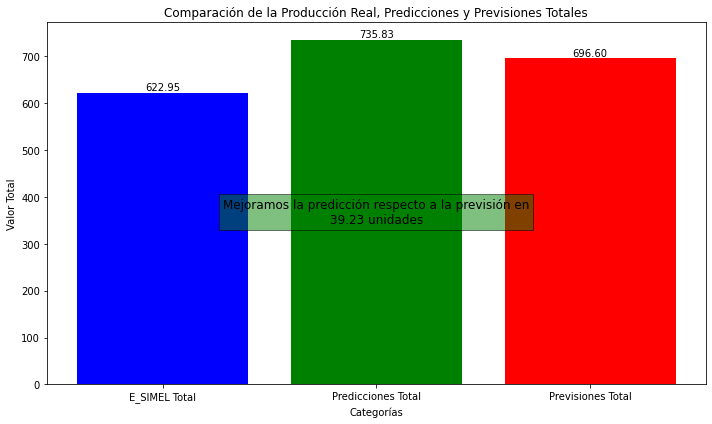

In [34]:
# Valores que cogemos para el gráfico

categorias = ['E_SIMEL Total', 'Predicciones Total', 'Previsiones Total']
valores = [suma_e_simel, sumas_totales_predicciones, sumas_previsiones]

# Creamos un gráfico de barras

plt.figure(figsize=(10, 6))
barra = plt.bar(categorias, valores, color=['blue', 'green', 'red'])

# Añadimos las etiqutas

for rect in barra:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom')

# Título del gráfico y ponemos las etiquteas a cada barra
    
plt.title('Comparación de la Producción Real, Predicciones y Previsiones Totales')
plt.xlabel('Categorías')
plt.ylabel('Valor Total')


# Ubicamos el texto de la diferencia

pos_y = valores[1] / 2
pos_x = categorias[1]
plt.text(pos_x, pos_y, f'Mejoramos la predicción respecto a la previsión en\n{diferencia:.2f} unidades', ha='center', va='center', fontsize=12, color='black', bbox=dict(facecolor='green', alpha=0.5))
plt.tight_layout()
plt.show()

In [35]:
suma_prevision = df_final['PREVISION'].sum()
suma_prevision

696.5999999999999

In [36]:
suma_E_SIMEL = df_final['E_SIMEL'].sum()
suma_E_SIMEL

622.953